# Polarization behaviors on Twitter: holistic analysis

In this notebook, the following steps are performed:
* Computation of studied polarization factors (normalized entropy)
* Computation of polarization scores, using the GRAIL metric
* Identification of behavioral classes, using the k-means algorithm
* Characterization of behavioral classes, using hierarchial regression

It can be run for two debates: 
* The COVID-19 debate, opposing the pro-vaccine and anti-vaccine communities.
* The Ukraine conflict debate, opposing the pro-Ukraine and pro-Russia communities. 

At certain stages, it is needed to comment and/or uncomment the code, depending on the debate being studied. 
By default, the Ukraine conflict debate is studied.

# Libraries import

As a first step, all necessary libraries are imported

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from scipy.stats import entropy
import itertools
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score

# Data import

Then, data are imported. 
For the holistic analysis, two datasets are required:
* edges: contains all the links between standard users and elite users (sources). One link corresponds to one retweet. 
* factors_data: contains computed factors for each standard users. These factors are either computed directly from collected dataset (number of retweets, proportion of retweets on the studied debate, frequency of interactions, number of elite users retweeted in each community), or from the graph built from the collected dataset (proximity centrality, betweenness centrality, PageRank)

In [61]:
#Required data to study the vaccine debate 
# edges = pd.read_csv('../data/vaccine_debate/interactions_vaccine_debate.csv', index_col=0)
# factors_data = pd.read_csv('../data/vaccine_debate/indicators_vaccine_debate.csv', index_col=0)

#Required data to study the Ukraine conflict debate
edges = pd.read_csv('../data/ukraine_debate/interactions_ukraine_debate.csv', index_col=0)
factors_data = pd.read_csv('../data/ukraine_debate/indicators_ukraine_debate.csv', index_col=0)

In [62]:
edges.head()

,Source,Target,Timeset,Side
0,S0U,E0U,2022-06-07,prorussia
1,S0U,E0U,2022-06-07,prorussia
2,S0U,E0U,2022-06-07,prorussia
3,S0U,E0U,2022-06-07,prorussia
4,S0U,E0U,2022-06-07,prorussia


In [63]:
print('Number of standard users:', edges['Source'].nunique())
print('Number of elite users:', edges['Target'].nunique())
print('Number of retweets:',len(edges))

Number of standard users: 1000
Number of elite users: 20
Number of retweets: 152802


In [64]:
#Create a list with identifier of each user
retweeters = edges['Source'].unique().tolist()

In [65]:
#Create lists with identifier of elite users of each community

#Vaccine debate
# provax_usernames = edges[edges['Side']=='provax']['Target'].unique().tolist()
# antivax_usernames = edges[edges['Side']=='antivax']['Target'].unique().tolist()

#Ukraine conflict debate
prorussia_usernames = edges[edges['Side']=='prorussia']['Target'].unique().tolist()
proukraine_usernames = edges[edges['Side']=='proukraine']['Target'].unique().tolist()

In [66]:
#vaccine_usernames = provax_usernames + antivax_usernames
war_usernames = prorussia_usernames + proukraine_usernames

# Polarization factors computation

3 polarization factors are studied: 
* Opinions, noted $H'_O$.
* Sources, in one community, noted $H'_{s,pro}$ or $H'_{s,proU}$ for the vaccine and Ukraine conflict debate respectively.  
* Sources, in the opppsing community, noted $H'_{s,anti}$ or $H'_{s,proR}$ for the vaccine and Ukraine conflict debate respectively.  

Each factor is computed with normalized entropy.
The sign of the opinion factor $H'_O$ is set according to the community within which the user interact more, and therefore ranges in [-1,1] . This allows to differentiate users accessing more one community or the other. For the clustering process, $H'_O$ is transformed so that it is included in [0,1]. To this end, computed $H'_o$ values are transformed using $H'_otrans = \frac{H'_o+1}{2}$. 

In [10]:
def normalized_entropy(distribution):
    return entropy(distribution, base=2)/np.log2(len(distribution))

In [11]:
#Function to compute factors
def compute_new_polarization_index_terms(edges_df, list_users, comm1, comm2, comm1_usernames, comm2_usernames):
    dict_x_term ={}
    dict_y_term_comm1 = {}
    dict_y_term_comm2 = {}

    nb_communities = 2
    nb_mentors_C1 = len(comm1_usernames)
    nb_mentors_C2 = len(comm2_usernames)
    list_usernames_total = comm1_usernames + comm2_usernames

    for i in tqdm(range(len(list_users))):
        df_user = edges_df[edges_df['Source']==list_users[i]] 
        comm1_links = len(df_user[df_user['Side']==comm1])
        comm2_links = len(df_user[df_user['Side']==comm2])
        degree = len(df_user)

        PC_user = [comm1_links/degree, comm2_links/degree]
        w1 = PC_user[0]
        w2 = PC_user[1]
        
        PM1_user = []
        PM2_user = []
        PM_user = []
        nb_communities_user = 0

        if comm1_links > 0:
            nb_communities_user = nb_communities_user+1          
            for j in range(len(comm1_usernames)): 
                nb_links_mentor_j = len(df_user[df_user['Target']==comm1_usernames[j]])
                PM1_user.append(nb_links_mentor_j/comm1_links)
        
        if comm2_links > 0:
            nb_communities_user = nb_communities_user+1
            for j in range(len(comm2_usernames)):
                nb_links_mentor_j = len(df_user[df_user['Target']==comm2_usernames[j]])
                PM2_user.append(nb_links_mentor_j/comm2_links)


        #Opinion factor
        Ho_user = normalized_entropy(PC_user)


        #Sources C1 factor
        if comm1_links > 0:
            Hs_user_comm1 = normalized_entropy(PM1_user)
        else :
            Hs_user_comm1 = 1

        #Sources C2 factor
        if comm2_links > 0:
            Hs_user_comm2 = normalized_entropy(PM2_user)
        else:
            Hs_user_comm2 = 1
        

        if w1 >= w2:
            dict_key = {list_users[i]:1-Ho_user}
            dict_x_term.update(dict_key)
        elif w1 < w2:
            dict_key = {list_users[i]:-(1-Ho_user)}
            dict_x_term.update(dict_key)


        dict_key = {list_users[i]:1-Hs_user_comm1}
        dict_y_term_comm1.update(dict_key)

        dict_key = {list_users[i]:1-Hs_user_comm2}
        dict_y_term_comm2.update(dict_key)

    return dict_x_term, dict_y_term_comm1, dict_y_term_comm2

In [67]:
#dict_x_term, dict_y_provax, dict_y_antivax = compute_new_polarization_index_terms(edges, retweeters, 'provax', 'antivax', provax_usernames, antivax_usernames)
dict_x_term, dict_y_proukraine, dict_y_prorussia = compute_new_polarization_index_terms(edges, retweeters, 'proukraine', 'prorussia', proukraine_usernames, prorussia_usernames)

100%|██████████| 1000/1000 [00:08<00:00, 117.61it/s]


In [68]:
#Creation of a DataFrame containing each factor

# df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
# df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
# df_polarization_index['y_term_provax'] = df_polarization_index.index.map(dict_y_provax)
# df_polarization_index['y_term_antivax'] = df_polarization_index.index.map(dict_y_antivax)

df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
df_polarization_index['y_term_proukraine'] = df_polarization_index.index.map(dict_y_proukraine)
df_polarization_index['y_term_prorussia'] = df_polarization_index.index.map(dict_y_prorussia)

In [69]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_proukraine,y_term_prorussia
S0U,-0.883150,0.058425,0.421442,0.752320
S1U,-1.000000,0.000000,0.000000,0.990539
S2U,-0.971317,0.014341,1.000000,0.399206
S3U,-1.000000,0.000000,0.000000,0.960814
S4U,-1.000000,0.000000,0.000000,0.515573


# Polarization scores computation and optimization using the GRAIL metric

Polarization is measured using the GRAIL metric, which is an invidivual polarization metric defined as follows:

$GRAIL(u) = \sum_i \alpha_i \frac{H^\prime(X_i)^{a_i}}{H^\prime(X_i)^{a_i} + (1-H^\prime(X_i))^{a_i}}$

It allows to measure polarization according to $i$ factors, that are transformed following a sigmoid-like transformation $\frac{x^a}{x^a+(1-x)^a}$, and weighted according to $\alpha$.

In our study, the factors that are combined are those previously computed (opinions and sources). 

In [70]:
#Definition of the function allowing to transform values following the sigmoid-like function on which GRAIL relies. 
def f_sigmoid(x, a):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [71]:
#Definition of the function allowing to compute GRAIL from computed factors. 
def compute_grail_from_terms(users, df_edges, df_terms, comm1, comm2,  alpha_comm, weighted_alpha=True, a1 = 1, a2 = 1, a3 = 1, oriented=True):
    dict_grail = {}

    for u in tqdm(users): 

        w1 = len(df_edges[(df_edges['Source']==u) & (df_edges['Side']==comm1)])/len(df_edges[df_edges['Source']==u])
        w2 = len(df_edges[(df_edges['Source']==u) & (df_edges['Side']==comm2)])/len(df_edges[df_edges['Source']==u])

        if weighted_alpha == True:
            alpha_sources_C1 = (1-alpha_comm) * w1
            alpha_sources_C2 = (1-alpha_comm) * w2
        
        else:
            if ((w1 > 0) and (w2 > 0)):
                alpha_sources_C1 = (1-alpha_comm)/2
                alpha_sources_C2 = (1-alpha_comm)/2
            elif ((w1 > 0) and (w2 == 0)):
                alpha_sources_C1 = (1-alpha_comm)
                alpha_sources_C2 = 0
            elif ((w1 == 0) and (w2 > 0)):
                alpha_sources_C1 = 0
                alpha_sources_C2 = (1-alpha_comm)

        opinion_user = abs(df_terms.loc[u, 'x_term'])
        sources_C1_user = df_terms.loc[u, 'y_term_'+comm1]
        sources_C2_user = df_terms.loc[u, 'y_term_'+comm2]

        grail_user = alpha_comm*f_sigmoid(opinion_user, a1) + alpha_sources_C1*f_sigmoid(sources_C1_user, a2) + alpha_sources_C2*f_sigmoid(sources_C2_user, a3)
        
        if oriented==True:
            if w1 < w2:
                grail_user = grail_user * ((-1)**1)
                
        dict_key = {u:grail_user}
        dict_grail.update(dict_key)
    return dict_grail

## GRAIL parameters tuning

In this previous step, the $\alpha$ and $a$ parameters are tuned so that the computed GRAIL scores are better fitted to the studied dataset. The optimization phase is based on the clustering performances: we are looking for the $\alpha$ and $a$ values allowing to better discriminate users.  

### Necessary functions
Here, all the functions required for clustering are defined.

In [18]:
#Search for the optimal value of k
def optimal_k_means(X):
    res = pd.DataFrame(columns=['k','Silhouette_index','DaviesBouldin_index'])
    for k in range(2, 13, 1):
        model = KMeans(n_clusters=k)
        model.fit_predict(X)
        db = davies_bouldin_score(X, model.labels_)
        silhouette_avg = silhouette_score(X, model.labels_)
        res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)  
    return res

In [19]:
#Application of the k-means algorithm with the selected optimal value of k
def apply_k_means(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)

    cluster_labels = model.labels_
    centers = pd.DataFrame(data=model.cluster_centers_, columns=X.columns)
    clusters = pd.DataFrame(centers, columns = X.columns)

    labels_df = pd.DataFrame(model.labels_.tolist(), columns=['Cluster'])
    size_clusters = labels_df.groupby('Cluster').size()
    size_clusters = size_clusters.to_frame()
    size_clusters.columns=['size']
    sizes = size_clusters['size'].tolist()
    clusters['size'] = sizes
    cols = clusters.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    clusters = clusters[cols]
    clusters = clusters.round(2)
    clusters = clusters.T

    return cluster_labels, centers, clusters

In [20]:
#Get resulting silhouette plot
def get_silhouette_plot(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)
    DB = davies_bouldin_score(X, model.labels_)
    print('Davies Bouldin Index : ', DB)

    silhouette_avg = silhouette_score(X, model.labels_)
    print('Silhouette Index : ', silhouette_avg)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 6)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (model.n_clusters + 1) * 10])

    sample_silhouette_values = silhouette_samples(X, model.labels_)
    y_lower = 10
    for i in range (model.n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % model.n_clusters),
                fontsize=14, fontweight='bold')

In [21]:
#Get results of successive clustering steps with differents values of parameters for the optimization step
def optim_clustering(list_a, y_term_c1, y_term_c2):
    df_polarization_optim = df_polarization_index.copy()
    optim_clustering = pd.DataFrame(index=['k','Silhouette', 'Davies-Bouldin'])
    for i in tqdm(list_a):
        def f_sigmoid_optim(x):
            return(x**(i)/(x**(i)+(1-x)**(i)))

        df_polarization_optim['x_final'] = df_polarization_optim['x_term_trans'].apply(f_sigmoid_optim)
        df_polarization_optim['y_C1_final'] = df_polarization_optim[y_term_c1].apply(f_sigmoid_optim)
        df_polarization_optim['y_C2_final'] = df_polarization_optim[y_term_c2].apply(f_sigmoid_optim)

        for j in np.arange(0,1.1, 0.1):
            name = 'alpha_'+str(round(j,1))+'a_'+str(round(i,2))
            j_bis = (1-j)/2

            x_name = 'x_'+name
            y_pro_name = 'y_pro_'+name
            y_anti_name = 'y_anti_'+name

            df_polarization_optim[x_name] = j*df_polarization_optim['x_final']
            df_polarization_optim[y_pro_name] = j_bis*df_polarization_optim['y_C1_final']
            df_polarization_optim[y_anti_name] = j_bis*df_polarization_optim['y_C2_final']

            X = df_polarization_optim[[x_name, y_pro_name, y_anti_name]]
            
            res = optimal_k_means(X)

            optim_clustering.loc['k',name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['k'].values[0]
            optim_clustering.loc['Silhouette',name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['Silhouette_index'].values[0]
            optim_clustering.loc['Davies-Bouldin', name] = res[res['Silhouette_index'] == res['Silhouette_index'].max()]['DaviesBouldin_index'].values[0]  

    return optim_clustering

### Optimization of GRAIL parameters

* Tested $a$ values are the following: [1/4, 1/3, 1/2, 1, 2, 3, 4]
* $\alpha$ values that are tested are all values in [0, 1] with $\Delta = 0.1$

It is important to note that:
* $a$ < 1 allows to better distinguish users with extreme values (-1 and 1)
* $a$ = 1 is equal to a linear function (no transformation)
* $a$ > 1 allows to better distinguish users with intermediare values ($\approx 0.5$)

In [72]:
#list of a values to test
list_a = [1/4, 1/3, 1/2, 1, 2, 3, 4]

In [73]:
#optim_clustering_vaccine = optim_clustering(list_a, 'y_term_provax', 'y_term_antivax')
optim_clustering_war = optim_clustering(list_a, 'y_term_proukraine', 'y_term_prorussia')

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI

In [74]:
#optim_clustering_vaccine.head()
optim_clustering_war.head()

,alpha_0.0a_0.25,alpha_0.1a_0.25,alpha_0.2a_0.25,alpha_0.3a_0.25,alpha_0.4a_0.25,alpha_0.5a_0.25,alpha_0.6a_0.25,alpha_0.7a_0.25,alpha_0.8a_0.25,alpha_0.9a_0.25,...,alpha_0.1a_4,alpha_0.2a_4,alpha_0.3a_4,alpha_0.4a_4,alpha_0.5a_4,alpha_0.6a_4,alpha_0.7a_4,alpha_0.8a_4,alpha_0.9a_4,alpha_1.0a_4
k,7.000000,7.000000,7.000000,6.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,10.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
Silhouette,0.856190,0.855037,0.851182,0.845782,0.856590,0.861674,0.882801,0.904953,0.927413,0.947872,...,0.677171,0.692662,0.713498,0.721709,0.730634,0.809718,0.873155,0.923590,0.963818,0.996226
Davies-Bouldin,0.173357,0.184652,0.214361,0.278454,0.371779,0.388454,0.329043,0.273219,0.224395,0.189377,...,0.433514,0.453804,0.485201,0.470260,0.449511,0.308775,0.202065,0.119753,0.055025,0.259699


In [75]:
#Save results into the results folder
#optim_clustering_vaccine.to_csv('../results/holistic_analysis/parameters_optimization/optimization_vaccine_debate.csv')
optim_clustering_war.to_csv('../results/holistic_analysis/parameters_optimization/optimization_ukraine_conflict_debate.csv')

#### Selected optimal parameters: 

Selected parameters are those allowing to have better clustering performances while giving each factor a reasonable weight so that every factor counts.

COVID-19 vaccine debate:
* $\alpha = 0.6$
* $a = 1/2$

Ukraine conflict debate:
* $\alpha = 0.6$
* $a = 1/3$ 

## GRAIL computation with tuned parameters

In [76]:
#Vaccine debate
#a=1/2

#Ukraine debate
a=1/3

In [77]:
def f_sigmoid_optim(x):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [78]:
#grail = compute_grail_from_terms(retweeters, edges, df_polarization_index, 'provax', 'antivax', alpha_comm=0.6, weighted_alpha=False,a1 = 0.5, a2 = 0.5, a3 = 0.5, oriented=True)
grail = compute_grail_from_terms(retweeters, edges, df_polarization_index, 'proukraine', 'prorussia', alpha_comm=0.6, weighted_alpha=False,a1 = 1/3, a2 = 1/3, a3 = 1/3, oriented=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


In [79]:
df_polarization_index['grail'] = df_polarization_index.index.map(grail)

In [80]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_proukraine,y_term_prorussia,grail
S0U,-0.883150,0.058425,0.421442,0.752320,-0.610498
S1U,-1.000000,0.000000,0.000000,0.990539,-0.929985
S2U,-0.971317,0.014341,1.000000,0.399206,-0.751531
S3U,-1.000000,0.000000,0.000000,0.960814,-0.897571
S4U,-1.000000,0.000000,0.000000,0.515573,-0.802077


# Identification of polarization behavior classes

Here we apply the clustering step on factors transformed according to optimized parameters:
* Each factor is weighted according to $\alpha$
* Each factor is transformed according to $a$

In [81]:
# df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
# df_polarization_index['y_pro_final'] = df_polarization_index['y_term_provax'].apply(f_sigmoid_optim)
# df_polarization_index['y_anti_final'] = df_polarization_index['y_term_antivax'].apply(f_sigmoid_optim)

df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
df_polarization_index['y_proU_final'] = df_polarization_index['y_term_proukraine'].apply(f_sigmoid_optim)
df_polarization_index['y_proR_final'] = df_polarization_index['y_term_prorussia'].apply(f_sigmoid_optim)

In [82]:
#We create a dataframe that will be used for the clustering
X = pd.DataFrame(columns=['x_final', 'y_pro_final', 'y_anti_final'])

In [83]:
# X['x_final'] = 0.6*df_polarization_index['x_final']
# X['y_pro_final'] = 0.2 * df_polarization_index['y_pro_final']
# X['y_anti_final'] = 0.2 * df_polarization_index['y_anti_final']

X['x_final'] = 0.6*df_polarization_index['x_final']
X['y_pro_final'] = 0.2 * df_polarization_index['y_proU_final']
X['y_anti_final'] = 0.2 * df_polarization_index['y_proR_final']

In [84]:
optimal_k_means(X)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_1

,k,Silhouette_index,DaviesBouldin_index
0,2.0,0.811952,0.291756
1,3.0,0.831220,0.332481
2,4.0,0.865177,0.319780
3,5.0,0.850517,0.401032
4,6.0,0.801145,0.453642
5,7.0,0.749205,0.459448
6,8.0,0.747629,0.502902
7,9.0,0.659393,0.508693
8,10.0,0.646726,0.475825
9,11.0,0.643799,0.495324


In [85]:
#For both debates, the optimal value of k is 4
labels, centers, clusters = apply_k_means(X, 4)
sort_clusters = clusters.sort_values(by='size', ascending=False,axis=1)

In [86]:
print('Centers of identified clusters:')
sort_clusters

Centers of identified clusters:


,0,1,2,3
size,448.0,344.00,156.00,52.00
x_final,0.6,-0.00,0.15,0.41
y_pro_final,0.1,0.00,0.18,0.10
y_anti_final,-0.0,0.12,0.10,0.17


In [87]:
map = {}
for i in range(4):
    map[sort_clusters.columns[i]]=clusters.columns[i]
labels_map = [map[i] for i in labels]

Davies Bouldin Index :  0.3197801140840406
Silhouette Index :  0.86517675256105


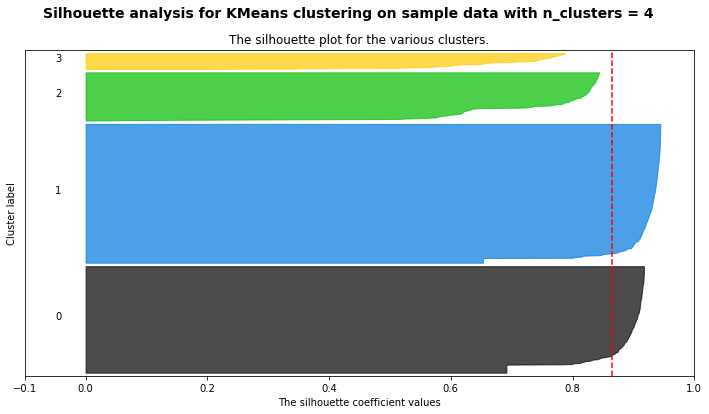

In [88]:
get_silhouette_plot(X, 4)

In [89]:
X['cluster'] = labels_map

In [90]:
df_polarization_index['cluster'] = labels_map

In [91]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_proukraine,y_term_prorussia,grail,x_final,y_proU_final,y_proR_final,cluster
S0U,-0.883150,0.058425,0.421442,0.752320,-0.610498,0.283614,0.47362,0.591541,2
S1U,-1.000000,0.000000,0.000000,0.990539,-0.929985,0.000000,0.00000,0.824964,1
S2U,-0.971317,0.014341,1.000000,0.399206,-0.751531,0.196226,1.00000,0.465988,2
S3U,-1.000000,0.000000,0.000000,0.960814,-0.897571,0.000000,0.00000,0.743928,1
S4U,-1.000000,0.000000,0.000000,0.515573,-0.802077,0.000000,0.00000,0.505193,1


In [46]:
#The final dataframe is saved in the results folder

#df_polarization_index.to_csv('../results/holistic_analysis/vaccine_debate_final_data.csv')
df_polarization_index.to_csv('../results/holistic_analysis/ukraine_conflict_debate_final_data.csv')

# Characterization of identified polarization behaviors classes using hierarchical regression

In this final step, we apply hierarchical regression to study how additionnal factors could explain the variations of GRAIL in each identified clusters. Results allow to better characterize each of these clusters, corresponding to behavioral classes.

## Data

In [92]:
#List of additional factors 

#Vaccine debate
#list_factors = ['RT_vaccine','prop_vaccine_RTs','frequency_weeks','nb_mentors_provax','nb_mentors_antivax','Betweenness_centrality','Closeness_centrality','PageRank']

#Ukraine conflict debate
list_factors= ['RT_war','prop_war_RTs','frequency_weeks','nb_mentors_prorussia','nb_mentors_proukraine','Betweenness_centrality','Closeness_centrality','PageRank']

In [93]:
complete_data = factors_data.merge(df_polarization_index[['cluster','grail']], right_index=True, left_index=True)
complete_data.head()

,RT_war,prop_war_RTs,frequency_weeks,nb_mentors_prorussia,nb_mentors_proukraine,Betweenness_centrality,Closeness_centrality,PageRank,cluster,grail
S27U,875,0.204105,1.0,6.0,0.0,0.001670,0.344723,0.001605,1,-0.908318
S77U,868,0.304882,1.0,1.0,0.0,0.000000,0.333661,0.001589,1,-1.000000
S31U,855,0.207625,1.0,4.0,0.0,0.000284,0.341717,0.001576,1,-0.885018
S161U,847,0.379141,1.0,1.0,0.0,0.000000,0.333661,0.001554,1,-1.000000
S188U,834,0.378919,1.0,1.0,0.0,0.000000,0.333661,0.001533,1,-1.000000


## Necessary functions

In [49]:
def ols_regression_optimization(ind_var,y):
    X = sm.add_constant(ind_var, prepend=False)
    
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]
    #print(model.summary())
    return model

In [50]:
def ols_regression(ind_var,y):

    X = sm.add_constant(ind_var, prepend=False)

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) # make the predictions by the model
    
    # Print out the statistics
    res = [("R_squared:", model.rsquared), ("R_squared_adjusted: ", model.rsquared_adj),
           ("F_value: ", model.fvalue), ("N_observations: ", model.nobs), 
           ("DF_model: ", model.df_model), ("DF_residuals: ", model.df_resid), 
           ("Coef: ", model.params), ("STD Err", model.bse), ("t values: ", model.tvalues), 
           ("p values", model.pvalues)]
    print(model.summary())

In [51]:
def optimization_OLS(df, ind_var, Y):
    factors_list = []
    R_squared_list = []
    for k in tnrange(1,len(list_factors) + 1):
        for combo in itertools.combinations(list_factors, k):
            factors_list.append(combo)
            model = ols_regression_optimization(df[list(combo)], Y)
            R_squared_list.append(model.rsquared)
    df_results = pd.DataFrame({'Factors':factors_list, 'R²':R_squared_list})
    
    # best_combination = list(df_results.sort_values(by='R²', ascending=False).head(1)['Factors'].values[0])
    # best_r_squared = df_results.sort_values(by='R²', ascending=False).head(1)['R²'].values[0]
    max_r2 = round(df_results['R²'].max(), 2)
    max_factors = df_results[df_results['R²'].round(2)==max_r2]
    max_factors = max_factors.reset_index(drop=True)

    list_combinations = []
    for i in range(max_factors.shape[0]):
        list_combinations.append(list(max_factors.loc[i,'Factors']))

    best_combination = min(list_combinations, key=len)
    best_r_squared = max_r2  
    
    print('Combinaison optimale :', best_combination, '\nNombre de facteurs :', len(best_combination), '\nR² max =', best_r_squared )
    return best_combination, df_results

In [52]:
def optim_regression(df, n_cluster, value_grail, factors, get_details=False):
    cluster = df[df['cluster']==n_cluster]
    ind_var = cluster[list_factors]
    Y = cluster[value_grail]

    best_combination, results = optimization_OLS(cluster, ind_var, Y)
    
    if get_details == True:
        ind_var_optim = cluster[best_combination]
        for i in range(1, ind_var_optim.shape[1]+1):
            ols_regression(ind_var_optim.iloc[:,:i], cluster[value_grail])

    return best_combination, results

## Power test

To ensure that results of hierarchical regression are statistically significant, we perform a power test.

In [53]:
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.stats.power import TTestPower

In [54]:
effect_size = 0.5
alpha = 0.05
power = 0.8

In [55]:
power = TTestPower()
n_test = power.solve_power(effect_size=0.5, power=0.8, alpha=0.05)
print('Minimum size of the sample to get trustable results:', math.ceil(n_test))

Minimum size of the sample to get trustable results: 34


In [56]:
%matplotlib inline

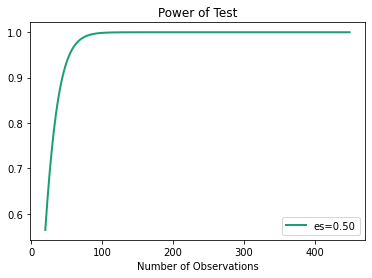

In [57]:
fig = TTestPower().plot_power(dep_var = 'nobs',
                              nobs = np.arange(20, 450),
                              effect_size = np.array([0.5]),
                              alpha = 0.05)
plt.show()

## Hierarchical regression in each identified cluster

In [94]:
ind_var = complete_data[list_factors]

In [95]:
ind_var.head()

,RT_war,prop_war_RTs,frequency_weeks,nb_mentors_prorussia,nb_mentors_proukraine,Betweenness_centrality,Closeness_centrality,PageRank
S27U,875,0.204105,1.0,6.0,0.0,0.001670,0.344723,0.001605
S77U,868,0.304882,1.0,1.0,0.0,0.000000,0.333661,0.001589
S31U,855,0.207625,1.0,4.0,0.0,0.000284,0.341717,0.001576
S161U,847,0.379141,1.0,1.0,0.0,0.000000,0.333661,0.001554
S188U,834,0.378919,1.0,1.0,0.0,0.000000,0.333661,0.001533


In [96]:
best_combination_cluster_1, results_cluster_1 = optim_regression(complete_data, 0, 'grail', list_factors, get_details=True)
best_combination_cluster_2, results_cluster_2 = optim_regression(complete_data, 1, 'grail', list_factors, get_details=True)
best_combination_cluster_3, results_cluster_3 = optim_regression(complete_data, 2, 'grail', list_factors, get_details=True)
best_combination_cluster_4, results_cluster_4 = optim_regression(complete_data, 3, 'grail', list_factors, get_details=True)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war', 'prop_war_RTs', 'nb_mentors_proukraine', 'Betweenness_centrality', 'Closeness_centrality', 'PageRank'] 
Nombre de facteurs : 6 
R² max = 0.77
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     15.18
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           0.000113
Time:                        16:51:15   Log-Likelihood:                 737.44
No. Observations:                 448   AIC:                            -1471.
Df Residuals:                     446   BIC:                            -1463.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err  

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war', 'prop_war_RTs', 'nb_mentors_prorussia', 'Betweenness_centrality', 'Closeness_centrality', 'PageRank'] 
Nombre de facteurs : 6 
R² max = 0.89
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     92.86
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.34e-19
Time:                        16:51:17   Log-Likelihood:                 536.38
No. Observations:                 344   AIC:                            -1069.
Df Residuals:                     342   BIC:                            -1061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war', 'prop_war_RTs', 'frequency_weeks', 'nb_mentors_prorussia', 'nb_mentors_proukraine', 'Closeness_centrality', 'PageRank'] 
Nombre de facteurs : 7 
R² max = 0.56
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     11.79
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           0.000766
Time:                        16:51:18   Log-Likelihood:                 126.54
No. Observations:                 156   AIC:                            -249.1
Df Residuals:                     154   BIC:                            -243.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_19316/1897647181.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(list_factors) + 1):


  0%|          | 0/8 [00:00<?, ?it/s]

Combinaison optimale : ['RT_war', 'prop_war_RTs', 'nb_mentors_prorussia', 'PageRank'] 
Nombre de facteurs : 4 
R² max = 0.49
                            OLS Regression Results                            
Dep. Variable:                  grail   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.434
Date:                Tue, 08 Aug 2023   Prob (F-statistic):              0.237
Time:                        16:51:20   Log-Likelihood:                 20.502
No. Observations:                  52   AIC:                            -37.00
Df Residuals:                      50   BIC:                            -33.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------